# Lecture 4: Performance analysis


![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1qRS7NIEctu9MaqafI5IpK9RWG3yyMYO1)

In [42]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2021-01-26 11:14:17


## Examining datasets

Use the MNIST digit dataset as a worked example in this lecture.

### Fetch MNIST data

In [43]:
# Common imports
import os
import numpy as np
np.random.seed(42) # To make this notebook's output stable across runs

# Fetch MNIST dataset
import requests  
  
url = "https://drive.google.com/uc?export=download&id=1_DqI-pH7gV5RuWxQ4IT1U7PrmSLLhc2a"
mnist = requests.get(url)
with open('mnist.npz', 'wb') as f:
    f.write(mnist.content)


### Extract features and targets

MNIST dataset is already split into standard training set (first 60,000 images) and test set (last 10,000 images).

In [44]:
mnist = np.load('mnist.npz')
X_train, y_train = mnist['x_train'], mnist['y_train']
X_test, y_test = mnist['x_test'], mnist['y_test']

y_train.shape, y_test.shape, type(y_train)

((60000,), (10000,), numpy.ndarray)

In [45]:
X_train.shape, X_test.shape, type(X_train)

((60000, 28, 28), (10000, 28, 28), numpy.ndarray)

Each datum corresponds to a 28 x 28 image.

Reshape X_train and X_test to a 2D array

In [46]:
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

In [47]:
import math
n_float = np.sqrt(X_train.shape[1])
n = math.floor(n_float)
print(n_float, n)

28.0 28


### Plot image of digit

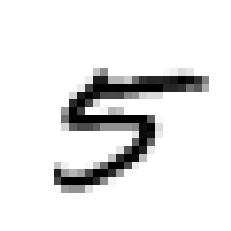

In [48]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

some_digit = X_train[41000]
some_digit_image = some_digit.reshape(n, n)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off");

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

### Plot selection of digits

In [49]:
# Extract digits
n_digits = 10
n_images = 10
example_images = np.zeros([n_images * n_digits, n*n])
for i in range(n_digits):
    example_images[i*n_images:(i+1)*n_images,:] =  X_train[np.where(y_train == i)][0:n_images,:]

<Figure size 720x720 with 0 Axes>

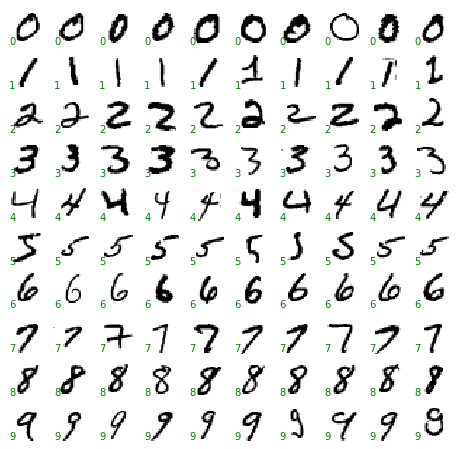

In [51]:
# Plot digits
plt.figure(figsize=(10,10))
fig, axes = plt.subplots(n_digits, n_images, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_images[i].reshape(n,n), cmap='binary', interpolation='nearest')
    ax.axis("off")
    ax.text(0.05, 0.05, str(i // n_images),
            transform=ax.transAxes, color='green')

In [52]:
def plot_digit(data):
    image = data.reshape(n, n)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off");

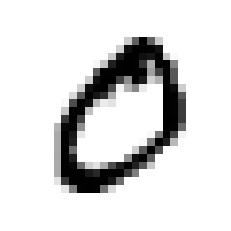

In [55]:
plot_digit(X_train[1])

Shuffle training data so not ordered by type.

洗牌训练数据，使其不按类型排序。

In [11]:
# Shuffle training data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

Construct a classify to distinguish between 5s and all other digits.

构造一个分类器来区分5和所有其他数字。

In [56]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [57]:
y_test_5

array([False, False, False, ..., False,  True, False])

### Train

Train a linear model using Stochastic Gradient Descent (good for large data-sets, as we will see later...).

使用随机梯度下降法训练线性模型(对于大数据集很好，我们将在后面看到…)。

In [58]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=10);
sgd_clf.fit(X_train, y_train_5)

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(max_iter=10, random_state=42)

Recall extracted `some_digit` previously, which was a 5.

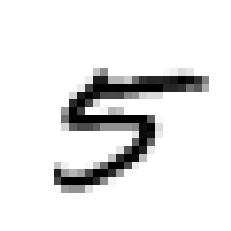

In [59]:
plot_digit(some_digit)

Predict class:

In [61]:
some_digit.shape

sgd_clf.predict([some_digit])


array([ True])

### Test accuracy

In [62]:
y_test = sgd_clf.predict(X_test)
y_test

array([False, False, False, ..., False,  True, False])

In [63]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_5)

0.9661

### Cross-validation

#### n-fold cross-validation

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture04_Images/5-fold-CV.png" style="width: 700px;"/>

[Image credit: [VanderPlas](https://github.com/jakevdp/PythonDataScienceHandbook)]

**Exercises:** *You can now complete Exercises 2-3 in the exercises associated with this lecture.*

### Consider naive classifier 

Classify everying as not 5.

In [65]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

What accuracy expect?

In [66]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Need to go beyond classification accuracy, especially for skewed datasets.

## Confusion matrix
混淆矩阵

Can gain further insight into performance by examining confusion matrix.

### Cross-validation prediction

`cross_val_predict` performs K-fold cross-validation, returing predictions made on each test fold.  Get clean prediction on each test fold, i.e. clean prediction for each instance in the training set.

In [67]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Compute confusion matrix

In [72]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[53885,   694],
       [ 1448,  3973]], dtype=int64)

Each row represents actual class, while each colum represents predicted class.

### Perfect confusion matrix

In [73]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Confusion matrix shows true/false-positive/negative classifications

- True-positive $\text{TP}$: number of true positives (i.e. *correctly classified* as *positive*)
- False-positive $\text{FP}$: number of false positives (i.e. *incorrectly classified* as *positive*)
- True-negative $\text{TN}$: number of true negatives (i.e. *correctly classified* as *negative*)
- False-negative $\text{FN}$: number of false negatives (i.e. *incorrectly classified* as *negative*)


<table>
  <tr>
    <td></td>
    <td></td>
    <td>**Predicted**</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>**Actual**</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

**Exercises:** *You can now complete Exercise 4 in the exercises associated with this lecture.*

## Precision and recall

- **Precision**: of predicted positives, proportion that are correctly classified (also called *positive predictive value*).
$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$


- **Recall**: of actual positives, proportion that are correctly classified (also called *true positive rate* or *sensitivity*).
$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

Remember:
<table>
  <tr>
    <td></td>
    <td></td>
    <td>**Predicted**</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>**Actual**</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

**Exercises:** *You can now complete Exercise 5 in the exercises associated with this lecture.*

### $F_1$ score

$F_1$ score is the *harmonic mean* of the precision and recall.

$$F_1 = \frac{2}{1/\text{precision} + 1/\text{recall}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN}+\text{FP}}{2}}$$

**Exercises:** *You can now complete Exercise 6 in the exercises associated with this lecture.*

$F_1$ favours classifiers that have similar (and high) precision and recall.

Sometimes may wish to favour precision or recall.

### Precision-recall tradeoff

Under the hood the classifier computes a *score*.  Binary decision is then made depending on whether score exceeds some *threshold*.

By changing the threshold, one can change the tradeoff between
precision and recall.

Scikit-Learn does not let you set the threshold directly but can access scores (confidence score for a sample is, e.g., the signed distance of that sample to classifying hyperplane).

In [89]:
some_digit = X_train[41000]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([15452.38337313])

Can then make prediction for given threshold.

In [78]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [79]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### Compute precision and recall for range of thresholds

In [90]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
#y_scores = y_scores[:,1] # uncomment to handle bug in scikit-learn 0.19.0

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [92]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [95]:
precision_recall_curve(y_train_5, y_scores)

(array([0.09058401, 0.09056881, 0.09057033, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-1052265.57965482, -1050710.53359882, -1050062.83101953, ...,
          441107.24671126,   458280.32400393,   479244.05004493]))

(-700000.0, 700000.0)

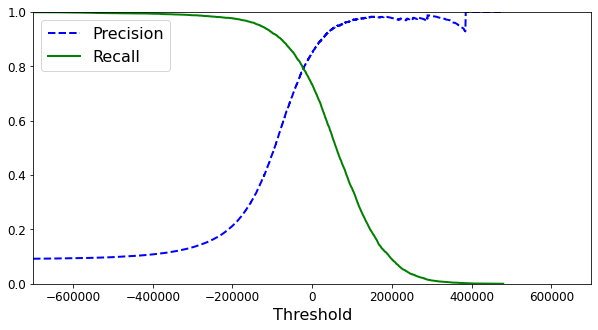

In [98]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

*Raising* the threshold *increases precision* and *reduces recall*.

Can select threshold of appropriate trade-off for problem at hand.

Note recall curve smoother than precision since recall related to actual positives and precision related to predicted positives.

## ROC curve

*Receiver operating characteristic* (ROC) 受试者工作特征
curve plots *true positive rate* (i.e. recall) against the *false positive rate* for different *thresholds*.

**Exercises:** *You can now complete Exercise 7 in the exercises associated with this lecture.*

### Plot ROC curve

In [99]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

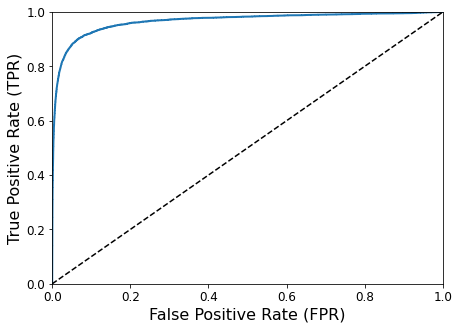

In [100]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(7, 5))
plot_roc_curve(fpr, tpr)

**Exercises:** *You can now complete Exercise 8 in the exercises associated with this lecture.*

Dashed line corresponds to random classifier.

Again, there is a trade-off.  As the threshold is reduced to increase the true positive rate, we get a larger false positive rate.

### Area under the ROC curve

Area under the ROC curve (AUC) is a common performance metric.

In [101]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9660920591881865

**Exercises:** *You can now complete Exercise 9 in the exercises associated with this lecture.*

### Comparing classifier ROC curves

In [102]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [103]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

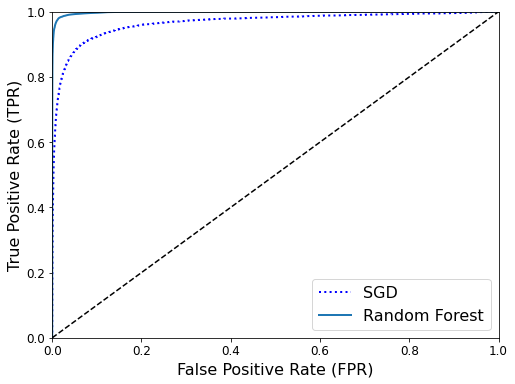

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

### Exercise: from the ROC curve, which method appears to work better?

Random Forests since get closer to the ideal point (i.e. top left of plot).

### Comparing metrics

In [105]:
# AUC
roc_auc_score(y_train_5, y_scores_forest), roc_auc_score(y_train_5, y_scores)

(0.9983436731328145, 0.9660920591881865)

In [106]:
# Precision
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), precision_score(y_train_5, y_train_pred)

(0.9905083315756169, 0.8512963359760017)

In [107]:
# Recall
recall_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred)

(0.8662608374838591, 0.7328906105884523)

In [108]:
# F_1
f1_score(y_train_5, y_train_pred_forest), f1_score(y_train_5, y_train_pred)

(0.9242275142688446, 0.7876685170499603)

## Progress so far

In [40]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/pqTntG1RXSY" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Multiclass classification

Binary classifiers distinguish between two classes.
Multiclass classifiers can distinguish between more than two classes.

Some algorithms can handle multiple classes directly (e.g. Random Forests, naive Bayes).
Others are strictly binary classifiers (e.g. Support Vector Machines, Linear classifiers).

### Multiclass classification strategies


However, there are various strategies that can be used to perform multiclass classification with binary classifiers.

- **One-versus-rest (OvR) / one-versus-all (OvA)**: train a binary classifier for each class, then select classification with greatest score across classifiers 
<br>(e.g. train a binary classifier for each digit).

- **One-versus-one (OvO)**: train a binary classifier for each pair of classes, then select classification that wins most duels 
<br>(e.g. train a binary classifier for each pairs of digits: 0 vs 1, 0 vs 2, ..., 1 vs 2, 1 vs 3, ...).

### Comparison of multiclass classification strategies

**One-versus-rest (OvR)**:
- $N$ classifiers for $N$ classes
- each classifier uses all of the training data

$\Rightarrow$ requires training relatively *few classifiers* but training each classifier can be *slow*.

**One-versus-one (OvO)**:
- $N(N-1)/2$ classifiers  for $N$ classes
- each classifier uses a subset of the training data (typically much smaller than overall training dataset)

$\Rightarrow$ requires training *many* classifiers but training each classifier can be *fast*.

### Preferred approach

Unless training binary classifier is very slow with large data-sets, OvR usually preferred.

In Scikit-Learn, if try to use binary classifier for a multiclass classification problem, OvR is automatically run.

In [111]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([5], dtype=uint8)

Can see OvR
performed by inspecting scores, where we have a score per classifier.  

The 5th score (starting from 0) is clearly largest.

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -81742.80600673, -226403.87485225, -310042.19433877,
        -173577.43026798,  -82855.74343468,   39922.35938292,
        -183200.20815396,   10437.2327332 , -240036.68142135,
        -160691.66786235]])

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

### OvO with Scikit-Learn

Can also perform OvO multiclass classification.

In [116]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=10))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit]), len(ovo_clf.estimators_)

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Max

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Max

(array([5], dtype=uint8), 45)

### Many classifiers can inherently classify multiple classes

Random Forest can directly classify multiple classes so OvR or OvO classification not required.

In [117]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [118]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [120]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

### Error analysis

Compute confusion matrix for multiclass classification.

In [122]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\msi\Anaconda3\envs\MLBDenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5363,    1,   39,   40,   40,   92,   53,    7,  279,    9],
       [   1, 6491,   13,   30,    8,   30,   11,    4,  135,   19],
       [  30,  250, 4518,  280,  105,   44,  109,   63,  538,   21],
       [  21,   33,   90, 5301,   22,  223,   27,   34,  317,   63],
       [  18,   12,   32,   17, 5223,    9,   37,   10,  302,  182],
       [  59,   49,   38,  357,  137, 3744,   93,   23,  841,   80],
       [  21,   19,   57,   10,   80,  221, 5400,    9,  100,    1],
       [  24,   32,   30,   55,  150,   12,    2, 5438,  190,  332],
       [  22,  163,   30,  154,   57,  101,   29,   13, 5239,   43],
       [  20,   19,   20,   79,  462,   31,    1,  184,  604, 4529]],
      dtype=int64)

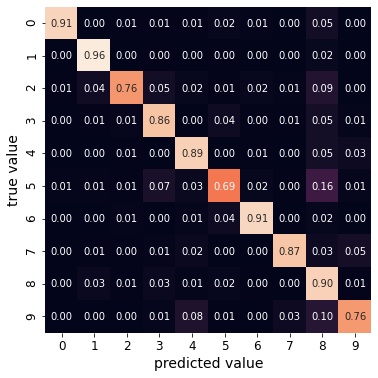

In [123]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(norm_conf_mx, square=True, annot=True, cbar=False, fmt='.2f')
plt.xlabel('predicted value')
plt.ylabel('true value');

**Exercises:** *You can now complete Exercise 10 in the exercises associated with this lecture.*

Performance analysis can provide insight into how to make improvements.

For example, for the previous dataset, one might want to consider trying to improve the performane of classifying 9 by collecting more training data for 7s and 9s.